In [1]:
from collections import OrderedDict
 
class LRUCache:
    def __init__(self, capacity: int):
        self.cache = OrderedDict()
        self.capacity = capacity
        self.stats = []
 
    def get(self, key: int) -> int:
        if key not in self.cache:
            self.stats.append(0)
            return -1
        else:
            self.stats.append(1)
            self.cache.move_to_end(key)
            return self.cache[key]
 
    def put(self, key: int, value: int) -> None:
        self.cache[key] = value
        self.cache.move_to_end(key)
        if len(self.cache) > self.capacity:
            self.cache.popitem(last = False)

In [2]:
import os.path as osp
import os
import torch
from overflowDataset import OpenFlowDataset

__file__ = os.path.abspath('')
path = osp.join(osp.dirname(osp.realpath(__file__)), '..', 'data', 'OpenFlow')

print("Loading dataset...")
dataset = OpenFlowDataset(path)
data = dataset[0]
data.n_id = torch.arange(data.num_nodes)

Loading dataset...


In [3]:
data

Data(x=[63497050, 128], edge_index=[2, 63497050], edge_attr=[63497050], n_id=[63497050])

In [4]:
data.edge_index

tensor([[      9,       1,      13,  ...,  144088, 5617035, 5579164],
        [      8,       1,       1,  ...,  275047, 4368648, 5579164]])

In [5]:
from tqdm import tqdm
from neighbor_sampler import NeighborSampler

subset = int(data.num_nodes / 100)
node_ids = torch.flatten(data.edge_index.t())

# Assume CPU cache is 10% of data
CPUCache  = LRUCache(int(subset/10))

# Assume GPU cache is 0.5% of data
GPUCache = LRUCache(int(subset/200))

temp_loader = NeighborSampler(data.edge_index, sizes=[10,10], node_idx=node_ids[:subset*2], batch_size=2)

pbar = tqdm(total=subset*2)
for batch_size, ids, adjs in temp_loader:
  for i in ids:
    i = int(i)
    val = CPUCache.get(i)
    if (val == -1):
      # Fetch from SSD
      CPUCache.put(i,i)
  pbar.update(batch_size)
pbar.close()

100%|██████████| 1269940/1269940 [06:22<00:00, 3322.70it/s]


In [17]:
def sum_intervals(vals):
    interval_size = 20000
    num_intervals = len(vals) // interval_size
    interval_sums = []
    for i in range(num_intervals):
        start_index = i * interval_size
        end_index = start_index + interval_size
        interval = vals[start_index:end_index]
        interval_sum = sum(interval) / interval_size
        interval_sums.append(interval_sum)
    return interval_sums

In [20]:
intervals = sum_intervals(CPUCache.stats)


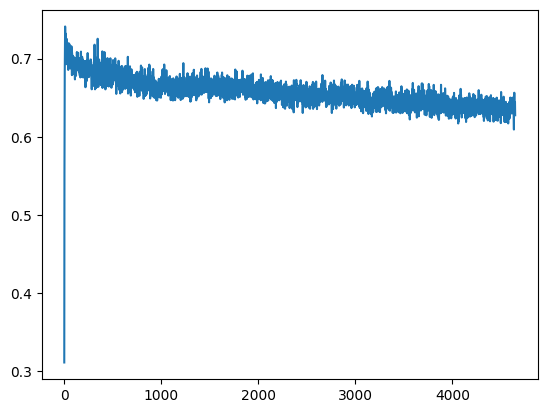

In [19]:
import matplotlib.pyplot as plt

plt.plot(intervals)

In [35]:
import scipy
import numpy as np

coo = data.edge_index.numpy()
v = np.ones_like(coo[0])
coo = scipy.sparse.coo_matrix((v, (coo[0], coo[1])), shape=(data.num_nodes, data.num_nodes))
csc = coo.tocsc()
csr = coo.tocsr()

csc_indptr_tensor = torch.from_numpy(csc.indptr.astype(np.int64))
csr_indptr_tensor = torch.from_numpy(csr.indptr.astype(np.int64))
out_num_neighbors = csr_indptr_tensor[1:] - csr_indptr_tensor[:-1]
in_num_neighbors = (csc_indptr_tensor[1:] - csc_indptr_tensor[:-1])


In [45]:
sorted_vals_out, indices_out = torch.sort(out_num_neighbors, descending=True)
sorted_vals_in, indices_in = torch.sort(in_num_neighbors, descending=True)

In [51]:
print(sorted_vals_in)
print(indices_in)

tensor([22258, 14743, 12732,  ...,     0,     0,     0])
tensor([   22656,  1144035,    29407,  ..., 22696800, 22696801, 22696802])


In [52]:
nds = torch.tensor([22656, 1144035], dtype=torch.long)
temp_loader = NeighborSampler(data.edge_index, sizes=[-1], node_idx=nds, batch_size=1)
for batch_size, ids, adjs in temp_loader:
    print(ids.size())

torch.Size([22258])
torch.Size([14743])


In [47]:
subset = int(data.num_nodes / 100)
node_ids = torch.flatten(data.edge_index.t())

# Assume CPU cache is 10% of data
CPUCache  = LRUCache(int(subset/10))

# Assume GPU cache is 0.5% of data
GPUCache = LRUCache(int(subset/200))

for i in range(int(subset/10)):
    val = int(out_num_neighbors[i])
    CPUCache.put(val, val)

In [48]:
temp_loader = NeighborSampler(data.edge_index, sizes=[10,10], node_idx=node_ids[:subset*2], batch_size=2)

pbar = tqdm(total=subset*2)
for batch_size, ids, adjs in temp_loader:
  for i in ids:
    i = int(i)
    val = CPUCache.get(i)
  pbar.update(batch_size)
pbar.close()

100%|██████████| 1269940/1269940 [05:26<00:00, 3887.77it/s]


In [49]:
intervals = sum_intervals(CPUCache.stats)

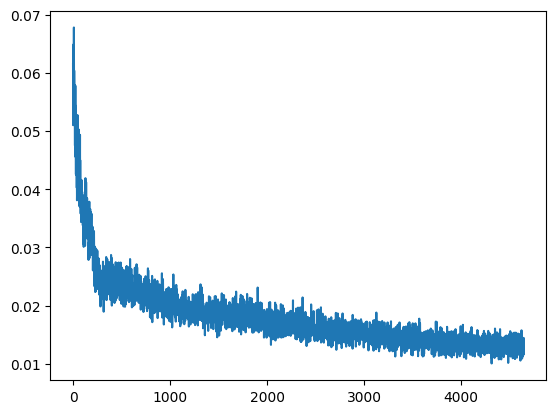

In [50]:
import matplotlib.pyplot as plt

plt.plot(intervals)

In [ ]:
# We find poor results if we use static caching. Perhaps this is due to the dataset used. Can we find a way to quantify the graph structure?